# Deep learning workshop - Exercise 1

This exercise will take you thtough training of a deep neural network using Keras. 

We will train a network to classify handwritten digits using the MNIST dataset.

We will cover the following topis: 
* Loading the data
* Building a simpel Kears model
* Training a basic network
* Evaluation of the model performance

## Basics of Jupyter Notebooks

Cell types:
* Markdown cells: Cells like this one with markdown-text in it
     - Change highlighted cell to markdown with: `m`
* Code cells: Python code cells.
    - Change highlighted cell to code with: `y`

When highlighting cell:
* `shift + enter`: Run cell
* `enter`: Enter edit mode in cell
* `esc`: Exit edit mode in cell

From header above:
* `Kernel > Interrupt`: Stop long running cell ( you might need this if running too many epochs ).
* `Kernel > Restart`: Restart entire notebook, if it really messes up do this and re-run relevant cells.

In [252]:
## These are some helper functions to plot the outputs of our models. Run the cell to save the functions. 

def plot_training_epochs(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.epoch, history.history['categorical_accuracy'])
    plt.plot(history.epoch, history.history['val_categorical_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    l = plt.legend(['training accuracy', 'validation accuracy'])

def plot_images_with_label(images, labels, class_):
    img_to_plot = images[labels[:, class_]==1, ...]

    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    for ax, img in zip(axes, img_to_plot):
        ax.imshow(array_to_img(img))
        ax.axis('off')

def print_confusion_matrix(y_true, y_hat, classes):
    return pd.DataFrame(confusion_matrix(y_true, y_hat),
                        index=['true_' + cls for cls in classes],
                        columns=['pred_' + cls for cls in classes])

def rand_by_mask(mask, n=4):
    return np.random.choice(np.where(mask)[0], n, replace=False)

def rand_by_correct(is_correct, y_true, y_hat, n=4):
    return rand_by_mask((y_true == y_hat) == is_correct, n=n)

def plot_image_ids(image_ids, generator):
    images = generator.x[image_ids]

    fig, axes = plt.subplots(1, len(images), figsize=(15, 10))
    for ax, img in zip(axes, images):
        ax.imshow(img[..., 0])
        ax.axis('off')

def plot_correct_classifications(y_true, y_hat, valid_gen, n=4):
    image_ids = rand_by_correct(True, y_true, y_hat, n=n)
    print("Predictions: %s" % ' '.join(str(i) for i in y_hat[image_ids]))
    plot_image_ids(image_ids, valid_gen)

def plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4):
    image_ids = rand_by_correct(False, y_true, y_hat, n=n)
    print("Predictions: %s" % ' '.join(str(i) for i in y_hat[image_ids]))
    plot_image_ids(image_ids, valid_gen)


## Loading data

First thing we need to do is load the data. In the following exercise you will work with the MNIST dataset. MNIST is a database of handwritten digits. The digist have been size-normalised and centered making them easy to work with. 

In [111]:
from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Convert the labels to one-hot encodings
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [112]:
# Load some of the things we need from keras
from keras.preprocessing.image import ImageDataGenerator          # generator to cycle through images
from keras.preprocessing.image import array_to_img                # function to convert arrays back to images 
from keras.applications.imagenet_utils import preprocess_input    # normalization function for ImageNet
from keras.preprocessing.image import load_img                    # function to load image

import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

UsageError: Line magic function `%` not found.


In [113]:
## Set up some global variables
# Batch size is how many images the network looks at at a time
batch_size = 64

# The image size is what we should scale the images to
image_size = (28, 28)

# This is the number of classes to classify.
#    This is important for what the output of the network should look like.
#    In this case we have 10 output classes.
n_classes = 10

In [171]:
## Create data generators
# Create a generator that runs `preprocess_input` on every loaded image.
data_generator = ImageDataGenerator()

# Create the training and validation generators.
# They use the image sizes, batch sizes, and paths to data set above.
train_gen = data_generator.flow(x_train, y_train, batch_size=batch_size)

valid_gen = data_generator.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

classes = list(map(str, range(1, 11)))

The generators `train_gen` and `test_gen` will iterate over the training and testing images. 

Each output will be a tuple of image-tensor and label-vector

In [115]:
images, labels = next(train_gen)

Imageres here contains a tensor with shape:

`(batch_size, image_height, image_width, image_channels)`

In [116]:
images.shape

(64, 28, 28, 1)

**Exercise**

Try plotting the first image

In [117]:
array_to_img(images[3])

The output of labels is one-hot encoding of the class

The dictionary of the class can be seen in:

In [118]:
train_gen.index_array

array([25159, 32770, 50619, ..., 18413, 26565, 51265])

In [119]:
labels

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

The helper function: 

`plot_images(images, labels, class)`

can plot the images from one of the classes (given the labels).

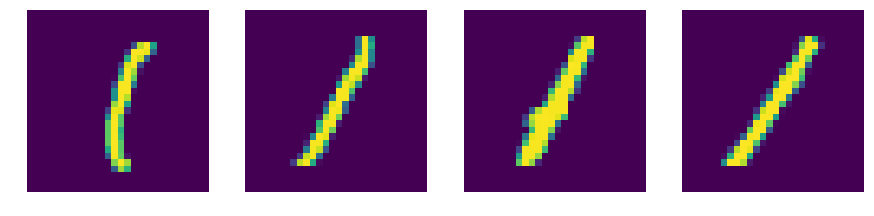

In [215]:
plot_images_with_label(images, labels, 1)

**Exercise**

Try plotting images from one of the other classes:

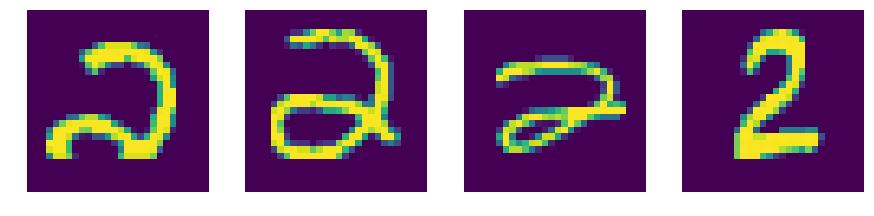

In [216]:
plot_images_with_label(images, labels, 2)

## Build a basic network

Using some predefined Keras components you can buils your own network. In the following section a simpel network has been defined, including two convolutional layers, two max pooling layers, a flatten layer and a dense layer. 

The network will have 10 outputs (0 - 9)

In [122]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input

In [ ]:
model = Sequential()
model.add(Conv2D(9, kernel_size=10, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(3, kernel_size=10, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


In [186]:
from keras.optimizers import Adam
opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

In [187]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 9)         90        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 9)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 3)         246       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 3)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 75)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                760       
Total params: 1,096
Trainable params: 1,096
Non-trainable params: 0
_________________________________________________________________


## Train a basic network

To train a model you can run `model.fit_generator`

Every time the model has trained once on the training data it will evaluate it's accuracy on the validation data. The resulting training and validation accuracies are printed.

When you are done running this you can plot the accuracies. 

In [189]:
history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs=3
)

Epoch 1/3
938/938 [==============================] - 16s 17ms/step - loss: 11.0996 - categorical_accuracy: 0.2209 - val_loss: 11.0844 - val_categorical_accuracy: 0.2147
Epoch 2/3
938/938 [==============================] - 10s 10ms/step - loss: 11.0165 - categorical_accuracy: 0.2261 - val_loss: 10.9961 - val_categorical_accuracy: 0.2199
Epoch 3/3
938/938 [==============================] - 8s 9ms/step - loss: 10.9377 - categorical_accuracy: 0.2312 - val_loss: 10.9115 - val_categorical_accuracy: 0.2266


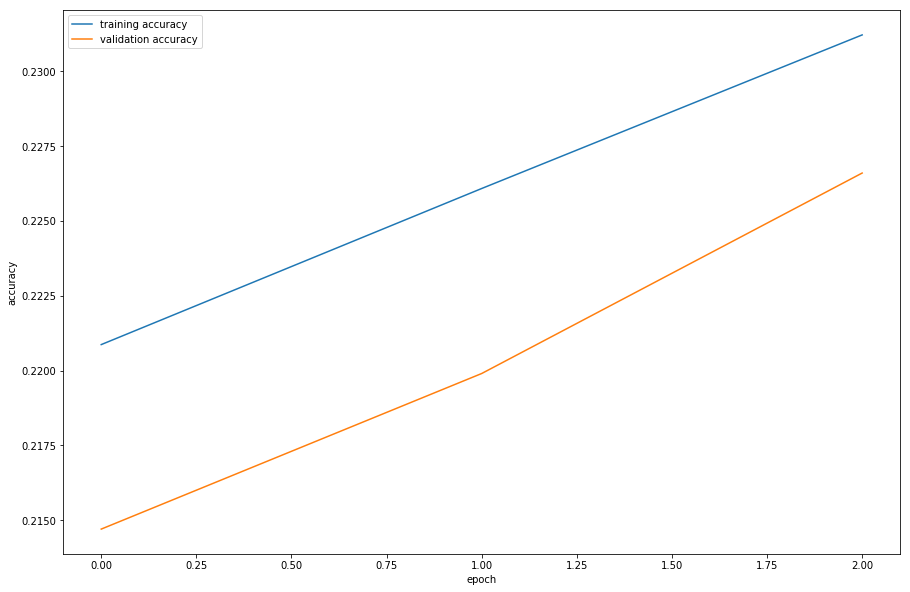

In [194]:
plot_training_epochs(history)

**Exercise**

* Try increasing the number of epochs - can you improve the model results?
* Try changing other parameters to obtain the best model performance

## Evaluate the model performance

The first thing we want to do, when having trained anetwork is to evaluate the performance. We can see how the network does during training above. The orange line is the validation accuracy after each epoch. 

But let's try and inscept the resulting predictions. 

We use a confusion matrix, first

In [219]:
# Get some metrics for evaluating the notebook
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

y_pred = model.predict_generator(valid_gen, verbose=1)
y_hat = np.argmax(y_pred, axis=1)
y_true = np.argmax(valid_gen.y, axis=1)

157/157 [==============================] - 1s 7ms/step


In [220]:
print('Accuracy: %0.4f' % accuracy_score(y_true, y_hat))
print('Confusion matrix:')
print_confusion_matrix(y_true, y_hat, classes=list(map(str, range(1, 11))))

Accuracy: 0.2266
Confusion matrix:


,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10
true_1,0,15,53,417,0,1,363,0,0,131
true_2,0,667,136,156,0,0,168,0,1,7
true_3,0,108,293,372,1,0,33,0,6,219
true_4,0,39,118,438,0,0,77,0,2,336
true_5,0,137,409,101,0,0,149,0,0,186
true_6,0,94,140,250,2,0,199,0,0,207
true_7,0,93,86,89,0,0,624,0,28,38
true_8,0,126,298,51,0,0,50,0,1,502
true_9,0,127,202,228,0,0,64,0,1,352
true_10,0,83,353,80,0,0,250,0,0,243


You can also plot random examples of correctly and incorrectly classified images using the cells below. 

As they are randomised you can see more examples by rerunning the cells. 

**Exercise**

Is there a pattern to incorrectly classified examples?

Predictions: 9 6 9 2


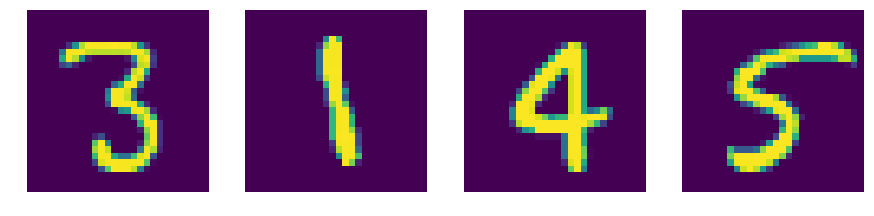

In [254]:
plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4)

Predictions: 6 2 1 1


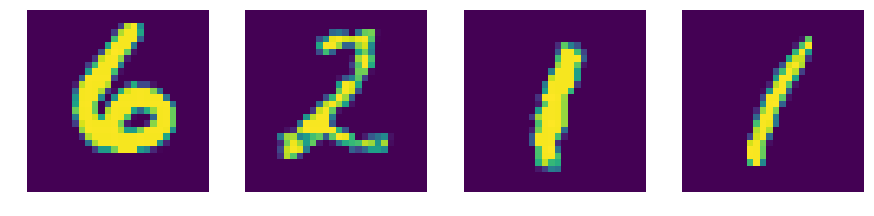

In [255]:
plot_correct_classifications(y_true, y_hat, valid_gen, n=4)

**Exercise**

* What is the model performance?
* How can you increase the performance?
* Report the highest performance and the method used to get this

## Feedback:

Please leave any feedback you migh have in the following text cell - then we'll try to improve our workshop for next time: